<a href="https://colab.research.google.com/github/syedsauda/CE888/blob/master/Assignment2/Assignment2_dataset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download and install scikit plot

In [0]:
pip install scikit-plot

#Importing Libraries

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score

from zipfile import ZipFile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Funtions

---

##Unzip file

In [0]:
def unzip(file_name):
  with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print('extracted: ',file_name)

##Split and classify dataset

In [0]:
def split_and_classify(df, feature):
  #Removing column to classify (TARGET)
  X = df.drop(columns=[feature]) 
  y = df[feature]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True) #Randomising nad splitting before classification
  
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)
  skplt.metrics.plot_roc(y_test, y_test_score)
  plt.show()
  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))
  return X,y;

##Classify train and test datasets

In [0]:
def classify_rfc(train_df, test_df, feature):

  X_train = train_df.drop(columns=[feature])
  y_train = train_df[feature]

  X_test = test_df.drop(columns=[feature])
  y_test = test_df[feature]
  
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_test_score = rfc.predict_proba(X_test)
  skplt.metrics.plot_roc(y_test, y_test_score)
  plt.show()
  print('AUC score: ', round(roc_auc_score(y_true=y_test, y_score=y_test_score[:,1]), 4))

##Plot Histogram of variable

In [0]:
def histo(df_test, df_train, feature):
  print("Histogram of dataset on '",feature,"'")
  histo = sns.distplot(df_test[[feature]].values.T[0], color="blue", kde=False, label="Testing data")
  histo = sns.distplot(df_train[[feature]].values.T[0], color="red", kde=False, label="Training data")
  legend = histo.legend()

---

#Downloading dataset and removing unused files

In [0]:
os.environ['KAGGLE_USERNAME'] = "syedsaud" # username from the json file
os.environ['KAGGLE_KEY'] = "7c3265f2a6cfd2e2354acf0a17b7a805" # key from the json file

!kaggle competitions download -c santander-customer-transaction-prediction #Download DATASET 1
!rm sample_submission.csv.zip
!rm test.csv.zip

unzip("/content/train.csv.zip")

!ls

 99% 124M/125M [00:02<00:00, 65.9MB/s]
100% 125M/125M [00:02<00:00, 60.2MB/s]
  0% 0.00/462k [00:00<?, ?B/s]
100% 462k/462k [00:00<00:00, 65.9MB/s]
 85% 106M/125M [00:01<00:00, 48.6MB/s] 
100% 125M/125M [00:01<00:00, 71.9MB/s]
extracted:  /content/train.csv.zip
sample_data  train.csv	train.csv.zip


#Load dataset into pandas dataframe

In [0]:
target_var = "target"
id_var = "ID_code"

orig_df_train = pd.read_csv('train.csv', header=0, sep=',', quotechar='"')

print(orig_df_train)

             ID_code  target    var_0  ...  var_197  var_198  var_199
0            train_0       0   8.9255  ...   8.5635  12.7803  -1.0914
1            train_1       0  11.5006  ...   8.7889  18.3560   1.9518
2            train_2       0   8.6093  ...   8.2675  14.7222   0.3965
3            train_3       0  11.0604  ...  10.2922  17.9697  -8.9996
4            train_4       0   9.8369  ...   9.5031  17.9974  -8.8104
...              ...     ...      ...  ...      ...      ...      ...
199995  train_199995       0  11.4880  ...   8.5326  16.6660 -17.8661
199996  train_199996       0   4.9149  ...   6.7419  15.9054   0.3388
199997  train_199997       0  11.2232  ...   8.7155  13.8329   4.1995
199998  train_199998       0   9.7148  ...  10.0342  15.5289 -13.9001
199999  train_199999       0  10.8762  ...   8.1857  12.1284   0.1385

[200000 rows x 202 columns]


#Creating test and training datasets with covariate shift

In [0]:
df_train = orig_df_train.where(orig_df_train["var_0"]>8.5).dropna().drop(columns=[target_var,id_var])
df_test = orig_df_train.where(orig_df_train["var_0"]<=8.5).dropna().drop(columns=[target_var,id_var])

#Detecting Covariate shift in data

Adding is_test column for later calssification

In [0]:
df_train['is_test'] = 0
df_test['is_test'] = 1

combine testing and training datasets and classify is_test

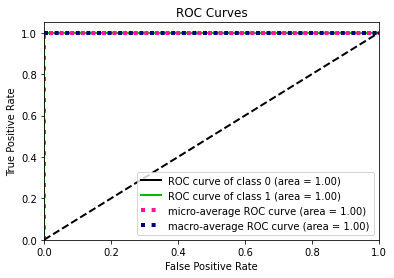

AUC score:  1.0


In [0]:
df_concat = pd.concat([df_train, df_test], axis = 0)
X,y = split_and_classify(df_concat,"is_test")

Since the AUC Score is higer than 0.8 we know that there is covarite shift in the datasets as the classifier is able to classify whether or not the given data is form the training or testing dataset.

---

---

Finding features causing covariate shift

In [0]:
drop_list = []

model = RandomForestClassifier(n_estimators = 50, max_depth = 5,min_samples_leaf = 5)
for i in X.columns:
    score = cross_val_score(model,pd.DataFrame(X[i]),y,cv=2,scoring='roc_auc')
    if (np.mean(score) > 0.8):
        drop_list.append(i)
        print(i,np.mean(score))

var_0 1.0


Histogram of variable(s) with covariate shift

Histogram of dataset on ' var_0 '


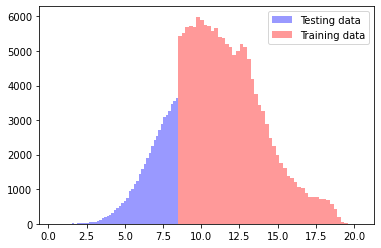

In [0]:
histo(df_test, df_train,"var_0")

#Fixing Covariate shift in datasets

Removing features that cause shift and classify 'is_test'

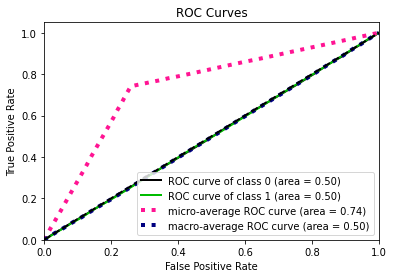

AUC score:  0.4969


In [0]:
df_concat.drop(columns=["var_0"],inplace=True)

unused,unused2 = split_and_classify(df_concat,"is_test")

Since the AUC Score is lower than 0.8 it means that we are unable to clssify whether the given data is from the testing or training dataset.
Hence, this indicates that the apparent covariate shift in data has been removed.

---

#Testing performance of classifier under co-variate shift in data 

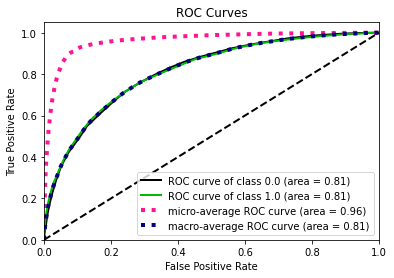

AUC score:  0.8138


In [0]:
df_train = orig_df_train.where(orig_df_train["var_0"]>8.5).dropna().drop(columns=[id_var])
df_test = orig_df_train.where(orig_df_train["var_0"]<=8.5).dropna().drop(columns=[id_var])
classify_rfc(df_train,df_test,"target")

#Testing performance of classifier with co-variate shift removed

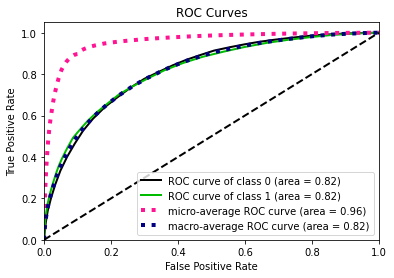

AUC score:  0.8174


In [0]:
df_no_covariate = orig_df_train.drop(columns=[id_var,"var_0"])
unused,unused2 = split_and_classify(df_no_covariate,"target")